  # Autoencoder - Baseline mode - Copy 1

# Setup

In [1]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/home/kevin/WSL-shared/Cellpainting/pt-snnl


In [2]:
import os
import sys
import csv
import json
import time
import pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        # print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil, getpass

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

WANDB_ACTIVE = False

os.environ["WANDB_NOTEBOOK_NAME"] = "Autoencoder_dev.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import wandb

from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace 
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import save_checkpoint_v2, load_checkpoint_v2, save_checkpoint_v3

from snnl.models import Model
from snnl.models import DNN 
from snnl.models import Autoencoder
from snnl.losses import SNNLoss

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']
2.2.1+cu118


In [3]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
# logger.info(f" Search path      : {sys.path}")

2024-06-21 20:14:21,094 - __main__ - INFO: -  Excution started : 2024_06_21_20:14:21 
2024-06-21 20:14:21,095 - __main__ - INFO: -  Pytorch version  : 2.2.1+cu118


### main(args)

In [4]:
LATENT_DIM = 150
HIDDEN_1   = '_512'
# HIDDEN_2   = '_256'
HIDDEN_2   = ''
DATE       = '20240616'
LOAD_EPOCH = '025'
EPOCHS     = 10
COMPOUNDS_PER_BATCH = 200

In [5]:
# if __name__ == "__main__":
cli_args =   f" --runmode            baseline" \
             f" --configuration      hyperparameters/ae_cp_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
             f" --gpu_id             0 "\
             f" --epochs             {EPOCHS} " \
             f" --cpb                {COMPOUNDS_PER_BATCH}" 

            #  f" --wandb              " \
            #  f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
             # f" --run_id             jyydyab3 " \
             # f" --seed               4321 " 
             # f" --exp_title           snglOpt-050Ltnt_512_sig "
             # f" --runmode            snnl" \
cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
args.ckpt


Namespace(random_seed=1234, runmode='baseline', configuration='hyperparameters/ae_cp_150_512_cpb.yaml', wandb=False, exp_id=None, ckpt=None, exp_title=None, epochs=10, gpu_id=0, cpb=200)

2024-06-21 20:15:11,437 - snnl.utils.utils - INFO: -  command line param random_seed               : [1234]
2024-06-21 20:15:11,438 - snnl.utils.utils - INFO: -  command line param runmode                   : [baseline]
2024-06-21 20:15:11,439 - snnl.utils.utils - INFO: -  command line param configuration             : [hyperparameters/ae_cp_150_512_cpb.yaml]
2024-06-21 20:15:11,440 - snnl.utils.utils - INFO: -  command line param wandb                     : [False]
2024-06-21 20:15:11,440 - snnl.utils.utils - INFO: -  command line param exp_id                    : [None]
2024-06-21 20:15:11,441 - snnl.utils.utils - INFO: -  command line param ckpt                      : [None]
2024-06-21 20:15:11,441 - snnl.utils.utils - INFO: -  command line param exp_title                 : [None]
2024-06-21 20:15:11,442 - snnl.utils.utils - INFO: -  command line param epochs                    : [10]
2024-06-21 20:15:11,443 - snnl.utils.utils - INFO: -  command line param gpu_id                    

In [6]:
args

namespace(project_name='CellPainting_Profiles',
          exp_id=None,
          exp_name_pfx=None,
          exp_name=None,
          exp_title='scpb200-150Ltnt_512',
          exp_description='AE Baseline - snglOpt, 150 dim latent, 512 Midlayer, 200 cpb',
          exp_folder=None,
          folder_sfx=None,
          random_seed=1234,
          units=[['linear', 1471, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 150],
                 ['linear', 150, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 1471]],
          activations=['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu'],
          input_shape=1471,
          code_units=150,
          embedding_layer=4,
          show_every=1,
          save_every=25,
          learning_rate=0.001,
          loss_factor=1.0,
          adam_weight_

In [33]:
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f" Checkpoint {args.ckpt} found")
        logger.info(f" Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f" *** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [7]:
if args.gpu_id is not None:
    _ = get_device()
    # print(f"Current device is : {current_device}")    
    current_device = set_device(args.gpu_id)
    current_device = get_device()


2024-06-16 13:34:31,175 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-06-16 13:34:31,176 - snnl.utils.utils - INFO: -  Switched to: Quadro GV100 - 0
2024-06-16 13:34:31,177 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100


## Define dataset and dataloaders

In [8]:
#### Load CellPainting Dataset
logging.info(f" load {args.dataset}")
train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

2024-06-16 13:34:32,306 - root - INFO: -  load cellpainting
2024-06-16 13:34:32,307 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-06-16 13:34:32,308 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-06-16 13:34:32,308 - snnl.utils.dataloader - INFO: -  type    :  train
2024-06-16 13:34:32,309 - snnl.utils.dataloader - INFO: -  start   :  0
2024-06-16 13:34:32,310 - snnl.utils.dataloader - INFO: -  end     :  240000
2024-06-16 13:34:32,310 - snnl.utils.dataloader - INFO: -  numrows :  240000
2024-06-16 13:34:32,311 - snnl.utils.dataloader - INFO: -  Each mini-batch contains 100.0 compounds with 3 samples per compound : total 300 rows
2024-06-16 13:34:32,311 - snnl.utils.dataloader - INFO: -  Number of 300 row full size batches per epoch: 800
2024-06-16 13:34:32,312 - snnl.utils.dataloader - INFO: -  Rows covered by 800 full size batches (

2024-06-16 13:34:32,318 - snnl.utils.dataloader - INFO: -  Each mini-batch contains 100.0 compounds with 3 samples per compound : total 300 rows
2024-06-16 13:34:32,319 - snnl.utils.dataloader - INFO: -  Number of 300 row full size batches per epoch: 80
2024-06-16 13:34:32,320 - snnl.utils.dataloader - INFO: -  Rows covered by 80 full size batches (300 rows) per epoch:  24000
2024-06-16 13:34:32,320 - snnl.utils.dataloader - INFO: -  Last partial batch contains : 0 rows
2024-06-16 13:34:32,321 - snnl.utils.dataloader - INFO: -  


In [9]:
# args.exp_id   = None
# args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
# args.exp_date = datetime.now().strftime('%Y%m%d')

## --- for restarts
# args.exp_id   = '0g8w13h6'
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
##-----------------
 
logger.info(f" Project Name     : {args.project_name}")
logger.info(f" Experiment Id    : {args.exp_id}")
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")
logger.info(f" Experiment Title : {args.exp_title}")
logger.info(f" Experiment Notes : {args.exp_description}")


2024-06-16 13:34:34,375 - __main__ - INFO: -  Project Name     : CellPainting_Profiles
2024-06-16 13:34:34,376 - __main__ - INFO: -  Experiment Id    : None
2024-06-16 13:34:34,378 - __main__ - INFO: -  Experiment Name  : None
2024-06-16 13:34:34,379 - __main__ - INFO: -  Experiment Date  : None
2024-06-16 13:34:34,380 - __main__ - INFO: -  Experiment Title : snglOpt-025Ltnt_512
2024-06-16 13:34:34,382 - __main__ - INFO: -  Experiment Notes : Autoencoder Training in Baseline mode - SnglOpt, 25 dim latent, 512 Midlayer


In [10]:
WANDB_ACTIVE = args.wandb
if WANDB_ACTIVE:
    if args.exp_id is not None:
        print("Resume")
        resume_wandb = True
    else:
        print("Initialize")
        resume_wandb = False
        args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
    
    wandb_run = init_wandb(args)
    
    args.exp_id = wandb_run.id
    args.exp_date = '2024'+args.exp_name[3:7]
    
    logger.info(f" WandB tracking started ")
    logger.info(f" Experiment Run id: {args.exp_id}   / {wandb_run.id}")
    logger.info(f" Experiment Name  : {args.exp_name} / {wandb_run.name} ")
    logger.info(f" Experiment Date  : {args.exp_date}  ")
    logger.info(f" Experiment Notes : {args.exp_description} / {wandb_run.notes} ")
else: 
    logger.info(f" *** W&&B Logging is INACTIVE *** ")
    args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
    args.exp_date = datetime.now().strftime('%Y%m%d')    

2024-06-16 13:34:39,735 - __main__ - INFO: -  *** W&&B Logging is INACTIVE *** 


In [11]:
logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-06-16 13:34:41,075 - __main__ - INFO: -  Experiment run id:  None
2024-06-16 13:34:41,076 - __main__ - INFO: -  Experiment Name  :  AE_0616_1334 
2024-06-16 13:34:41,077 - __main__ - INFO: -  Experiment Date  :  20240616 
2024-06-16 13:34:41,077 - __main__ - INFO: -  Experiment Title :  snglOpt-025Ltnt_512 
2024-06-16 13:34:41,078 - __main__ - INFO: -  Experiment Notes :  Autoencoder Training in Baseline mode - SnglOpt, 25 dim latent, 512 Midlayer


# Define autoencoder model

## Override arguments

In [12]:
# args.temperature   = 0.0
# args.loss_factor   = 1.0        ## 2.0e+00
# args.snnl_factor   = 0.0       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 0.0e-04    ## 1e-4
# print(f"   Latent dim        {args.code_units}")
# print(f"   loss_factor       {args.loss_factor}")
# print(f"   snnl_factor       {args.snnl_factor}")
# print(f"   temperature       {args.temperature}")
# print(f"   learning_rate     {args.learning_rate}")
# print(f"   temperatureLR:    {args.temperatureLR}")
args.embedding_layer

4

## Define Model

In [13]:
model = define_autoencoder_model(args, embedding_layer = args.embedding_layer, device = current_device)
model.device
model.embedding_layer

Defining model in baseline mode
    Model_init()_    -- AE - support for unsupervised in autoencoding mode is True
    layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
    layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
    layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    4  type:linear           input:    512  output:     25    weights: [25, 512]   
    layer pair:    5  type:linear           input:     25  output:    512    weights: [512, 25]   
    layer pair:    6  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    7  type:linear           input:    512  output:   1024    weights: [1024, 512]   
    layer pair:    8  type:relu             input:      0  output:      0    weights: [0, 0]   

/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


'cuda:0'

4

In [14]:
list_namespace(args)


command line parms : 
-----------------------
SGD_weight_decay.........  0
activations..............  ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
adam_weight_decay........  0
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start...............

In [15]:
if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = True)

# Load model checkpoint 

In [16]:
if args.ckpt is not None:
    resume_training = True
    mdl , last_epoch = load_checkpoint_v2(model, args.ckpt)  
    model.train()
    model.device = current_device
    model = model.cuda(device=current_device)
    logging.info(f" Loaded Model device {model.device} -  Last completed epoch : {last_epoch}")
    starting_epoch = last_epoch
    epochs = last_epoch + args.epochs
    logging.info(f" RESUME TRAINING - Run epochs {starting_epoch+1} to {epochs} ")
    
else:
    resume_training = False
    starting_epoch = 0
    epochs = args.epochs
    logging.info(f" INITIALIZE TRAINING - Run epochs {starting_epoch+1} to {epochs} ")

2024-06-16 13:34:53,719 - root - INFO: -  INITIALIZE TRAINING - Run epochs 1 to 10 


In [17]:
model.training_history

{'gen': {'trn_best_metric': 0,
  'trn_best_metric_ep': 0,
  'trn_best_loss': inf,
  'trn_best_loss_ep': 0,
  'val_best_metric': 0,
  'val_best_metric_ep': 0,
  'val_best_loss': inf,
  'val_best_loss_ep': 0},
 'trn': defaultdict(list, {}),
 'val': defaultdict(list, {})}

In [18]:
print()
print(f" Current device      : {current_device}")
print(f" Model device        : {model.device}")
print(f" SNNL temperature    : {model.temperature}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor         : {model.snnl_factor}")
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f" Use Scheduler       : {model.use_scheduler}") 
print(f" Use snnl            : {model.use_snnl}") 
if model.use_snnl:
    print(f" Temperature         : {model.temperature.item()}")
    print(f" Temperature LR      : {model.optimizer.param_groups[1]['lr']}") 
    print(f" Use Temp Scheduler  : {model.use_temp_scheduler}") 
    if model.temp_scheduler:
        print(f" Temp Scheduler      : {model.temp_scheduler}") 
    if model.temp_optimizer:
        print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

if resume_training:    
    for th_key in ['trn', 'val']:
        for k,v in model.training_history[th_key].items():
            if isinstance(v[-1],str):
                print(f" {k:20s} : {v[-1]:s}  ")
            else:
                print(f" {k:20s} : {v[-1]:6f} ")
        print()    
print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {starting_epoch+1:4d} of {epochs:4d}")


 Current device      : cuda:0
 Model device        : cuda:0
 SNNL temperature    : 0
 Learning rate       : 0.001
 snnl_factor         : 0.0
 loss_factor         : 1.0
 monitor_grads_layer : None
 Use Scheduler       : True
 Use snnl            : False

 20240616_133515  epoch    1 of   10


In [19]:
if 'gen' not in model.training_history:
    print(f" Define self.training_history['gen'] ")
    model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': np.inf, 'trn_best_loss_ep' : 0 ,
                                    'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': np.inf, 'val_best_loss_ep' : 0 }        

    for key in ['trn', 'val']:
        tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
        model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
        model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
        
        tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
        model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
        model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]

model.best_metric = model.training_history['gen'][f'val_best_metric']  
model.best_epoch  = model.training_history['gen'][f'val_best_metric_ep']  


In [20]:
logger.info(f" Best training loss     : {model.training_history['gen']['trn_best_loss']:6f} - epoch: {model.training_history['gen']['trn_best_loss_ep']}") 
logger.info(f" Best training metric   : {model.training_history['gen']['trn_best_metric']:6f} - epoch: {model.training_history['gen']['trn_best_metric_ep']}") 
logger.info(f" ") 
logger.info(f" Best validation loss   : {model.training_history['gen']['val_best_loss']:6f} - epoch: {model.training_history['gen']['val_best_loss_ep']}") 
logger.info(f" Best validation metric : {model.training_history['gen']['val_best_metric']:6f} - epoch: {model.training_history['gen']['val_best_metric_ep']}") 
logger.info(f" ")
logger.info(f" Model best metric      : {model.best_metric:6f} - epoch: {model.best_epoch}") 


2024-06-16 13:35:29,851 - __main__ - INFO: -  Best training loss     :    inf - epoch: 0
2024-06-16 13:35:29,852 - __main__ - INFO: -  Best training metric   : 0.000000 - epoch: 0
2024-06-16 13:35:29,852 - __main__ - INFO: -  
2024-06-16 13:35:29,853 - __main__ - INFO: -  Best validation loss   :    inf - epoch: 0
2024-06-16 13:35:29,854 - __main__ - INFO: -  Best validation metric : 0.000000 - epoch: 0


2024-06-16 13:35:29,855 - __main__ - INFO: -  
2024-06-16 13:35:29,855 - __main__ - INFO: -  Model best metric      : 0.000000 - epoch: 0


# Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [21]:
# model.training_history['trn'][f'trn_ttl_loss']
# model.best_loss = np.inf
# model.best_loss

In [22]:
# model.temperature = 40.0
# model.snnl_factor = 0.5
# model.loss_factor = 0.1
# model.temperatureLR = 1e-4
# model.optimizer.param_groups[0]['lr'] = 0.001
# model.temp_optimizer.param_groups[0]['lr'] = 0.000005
# model.monitor_grads_layer = -2
# print()
# if model.use_snnl:
#     print(f" Use snnl            : {model.use_snnl}") 
#     print(f" snnl_factor         : {model.snnl_factor}")
#     print(f" temperature         : {model.temperature.item()}")
#     print(f" Temperature LR      : {model.optimizer.param_groups[1]['lr']}") 
#     # print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
#     print(f" Use Temp Scheduler  : {model.use_temp_scheduler}") 
#     print(f" Temp Scheduler      : {model.temp_scheduler}") 
# print(f"\n run epochs {starting_epoch+1} to {epochs} ")

In [23]:
if WANDB_ACTIVE:
    wandb.config.update(args)

In [24]:
#
#  Running Training Loop
#

logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")
logger.info(f" Run epochs {starting_epoch+1:4d} to {epochs:4d}")

2024-06-16 13:35:44,708 - __main__ - INFO: -  Experiment run id:  None
2024-06-16 13:35:44,709 - __main__ - INFO: -  Experiment Name  :  AE_0616_1334 
2024-06-16 13:35:44,710 - __main__ - INFO: -  Experiment Date  :  20240616 
2024-06-16 13:35:44,711 - __main__ - INFO: -  Experiment Title :  snglOpt-025Ltnt_512 
2024-06-16 13:35:44,712 - __main__ - INFO: -  Experiment Notes :  Autoencoder Training in Baseline mode - SnglOpt, 25 dim latent, 512 Midlayer
2024-06-16 13:35:44,713 - __main__ - INFO: -  Run epochs    1 to   10


In [25]:
header = True

for epoch in range(starting_epoch,epochs):
    train_loss = model.epoch_train(train_loader, epoch)
    val_loss = model.epoch_validate(val_loader, epoch)
    
    display_epoch_metrics(model, epoch, epochs, header)
    header = False
    model.scheduling_step(val_loss)
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y     for x,y in model.training_history['gen'].items()} | \
                        {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if model.new_best:
        # filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_BEST_ep_{epoch+1:03d}"
        save_checkpoint_v3(epoch+1, model, args, update_best=True)        
    if (epoch + 1) % args.save_every == 0:
        # filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
        # save_checkpoint_v2(epoch+1, model, filename, update_latest=False, update_best=False)    
        save_checkpoint_v3(epoch+1, model, args)    
        
print(f"Last Epoch {epoch+1}")
save_checkpoint_v3(epoch+1, model, args, update_latest=True)            

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |   R2                     |   Vld_loss    PrimLoss      SNNL   |   R2                     |    LR       temp LR   |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|-----------------------|
13:38:13 ep   1 / 10 |   0.489790    0.489790    0.000000 |   0.000000    0.0000e+00 |  -1.7375      1          |   0.366367    0.366367    0.000000 |   0.3698      1          |   0.001000   0.000000 |


2024-06-16 13:40:36,090 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_baseline_20240616_snglOpt-025Ltnt_512_BEST.pt - epoch: 2


13:40:36 ep   2 / 10 |   0.335099    0.335099    0.000000 |   0.000000    0.0000e+00 |   0.4236      2          |   0.307153    0.307153    0.000000 |   0.4911      2          |   0.001000   0.000000 |
13:42:57 ep   3 / 10 |   0.301246    0.301246    0.000000 |   0.000000    0.0000e+00 |   0.5575      3          |   0.290017    0.290017    0.000000 |   0.5582      3          |   0.001000   0.000000 |


2024-06-16 13:42:58,296 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_baseline_20240616_snglOpt-025Ltnt_512_BEST.pt - epoch: 3


13:45:20 ep   4 / 10 |   0.292795    0.292795    0.000000 |   0.000000    0.0000e+00 |   0.5557      3          |   0.287513    0.287513    0.000000 |   0.5524      3          |   0.001000   0.000000 |
13:47:42 ep   5 / 10 |   0.286024    0.286024    0.000000 |   0.000000    0.0000e+00 |   0.5622      5          |   0.283358    0.283358    0.000000 |   0.5651      5          |   0.001000   0.000000 |


2024-06-16 13:47:42,835 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_baseline_20240616_snglOpt-025Ltnt_512_BEST.pt - epoch: 5


13:50:05 ep   6 / 10 |   0.281846    0.281846    0.000000 |   0.000000    0.0000e+00 |   0.5736      6          |   0.276666    0.276666    0.000000 |   0.5636      5          |   0.001000   0.000000 |
13:52:29 ep   7 / 10 |   0.276069    0.276069    0.000000 |   0.000000    0.0000e+00 |   0.5819      7          |   0.274245    0.274245    0.000000 |   0.5648      5          |   0.001000   0.000000 |
13:54:52 ep   8 / 10 |   0.281861    0.281861    0.000000 |   0.000000    0.0000e+00 |   0.5734      7          |   0.276532    0.276532    0.000000 |   0.5770      8          |   0.001000   0.000000 |


2024-06-16 13:54:52,536 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_baseline_20240616_snglOpt-025Ltnt_512_BEST.pt - epoch: 8


13:57:14 ep   9 / 10 |   0.273210    0.273210    0.000000 |   0.000000    0.0000e+00 |   0.5798      7          |   0.271013    0.271013    0.000000 |   0.5718      8          |   0.001000   0.000000 |


2024-06-16 13:59:37,979 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_baseline_20240616_snglOpt-025Ltnt_512_LAST_ep_010.pt - epoch: 10


13:59:37 ep  10 / 10 |   0.270285    0.270285    0.000000 |   0.000000    0.0000e+00 |   0.5800      7          |   0.271447    0.271447    0.000000 |   0.5625      8          |   0.001000   0.000000 |
Last Epoch 10


### Close WandB Logging

In [26]:
if WANDB_ACTIVE:
    wandb_run.finish()
    WANDB_ACTIVE = False

In [ ]:
starting_epoch, epochs 

# starting_epoch = 350
# epochs = 35
# starting_epoch = epochs
# epochs += 100
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [27]:
for epoch in range(epochs):
    display_epoch_metrics(model, epoch)

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |   R2                     |   Vld_loss    PrimLoss      SNNL   |   R2                     |    LR       temp LR   |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|-----------------------|
13:38:13 ep   1 / 10 |   0.489790    0.489790    0.000000 |   0.000000    0.0000e+00 |  -1.7375      7          |   0.366367    0.366367    0.000000 |   0.3698      8          |   0.001000   0.000000 |
13:40:36 ep   2 / 10 |   0.335099    0.335099    0.000000 |   0.000000    0.0000e+00 |   0.4236      7          |   0.307153    0.307153    0.000000 |   0.4911      8          |   0.001000   0.000000 |
13:42:57 ep   3 / 10 |   0.301246    0.301246    0.000000 |   0.000000    0.0000e+00 |   0.5575      7          |   0.290017    0.290017    0.000000 |   0.5582      8          |   0.001000   0

# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

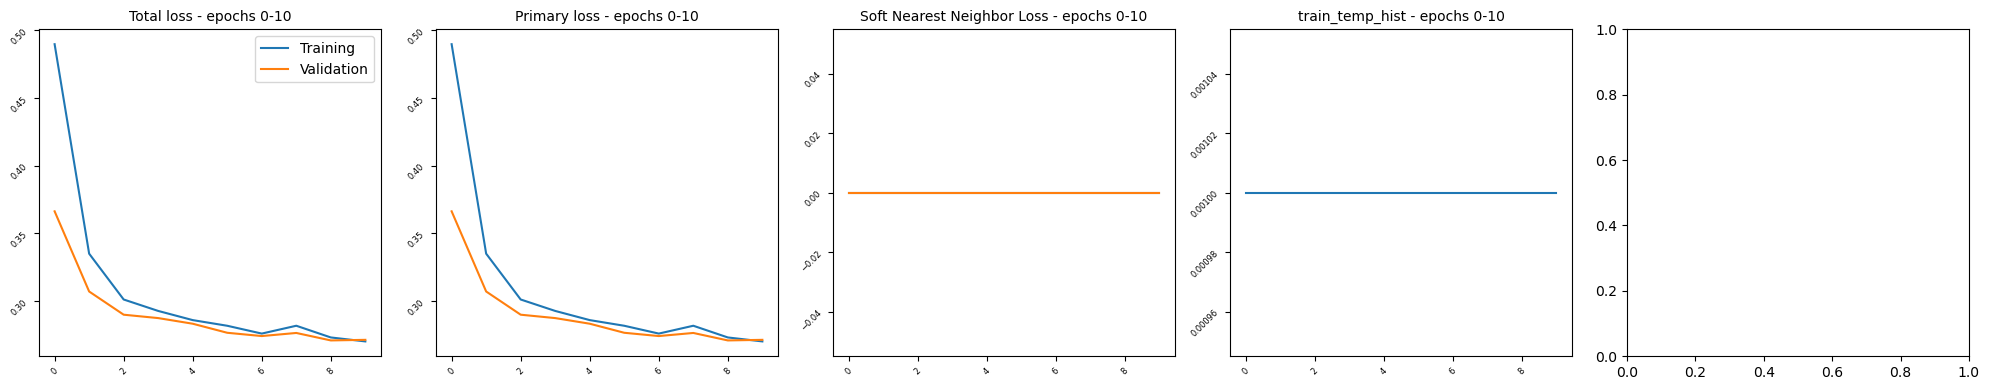

In [35]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

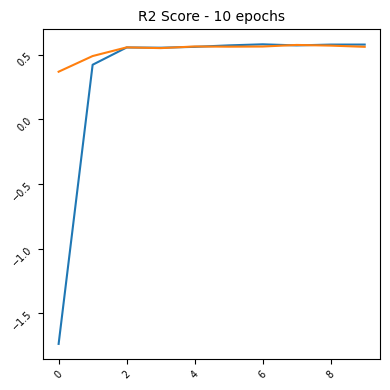

In [36]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
# export_results(model=model, filename=filename)
# save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

In [ ]:
model.name
args.runmode
ex_timestamp
ex_title
epoch
model.snnl_factor

In [ ]:
filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
print(filename)

In [ ]:
filename = f"{model.name}_{args.model.lower()}_{ex_timestamp}_{ex_title}_{epoch+1:03d}_copy"
print(filename)
    # export_results(model=model, filename=filename)
save_checkpoint_2(epochs, model, filename, update_latest=False, update_best=False)  

# Load model

In [39]:
# ex_epochs = 200
# ex_mode = 'snnl'
ex_runmode = 'baseline'
ex_date = "20240616"
ex_title="snglOpt-025Ltnt"
# ex_title="secondTry"
# ex_title="dropout04"
# title="autoencoder"
# title='Xentropy'

In [40]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*.pt"
print(file_pattern)

AE_baseline_20240616_snglOpt-025Ltnt_010.pt
AE_baseline_20240616_snglOpt-025Ltnt_*.pt


In [41]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

['AE_baseline_20240616_snglOpt-025Ltnt_512_BEST_ep_008.pt']

[8]

In [44]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [45]:
filename = f"{model.name}_{args.runmode}_{ex_date}_{ex_title}_ep_{ex_epoch:03d}"   
filename = filelist[-1]
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

AE_baseline_20240616_snglOpt-025Ltnt_512_BEST_ep_008.pt

 *** Checkpoint EXISTS *** 



In [46]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

2024-06-16 12:20:33,115 - root - INFO: -  Load model checkpoint from  AE_baseline_20240616_snglOpt-025Ltnt_512_BEST_ep_008.pt


2024-06-16 12:20:33,149 - snnl.utils.utils - INFO: -  ==> Loaded from checkpoint AE_baseline_20240616_snglOpt-025Ltnt_512_BEST_ep_008.pt successfully. last epoch on checkpoint: 8



 last epoch : 8


In [87]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

cuda:1
cuda:0
cuda:1


In [88]:
print(current_device)
model.train()
model = model.cuda(device=current_device)
print(model.device)

cuda:1


Autoencoder(
  (primary_criterion): MSELoss()
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=1471, bias=True)
  )
)

cuda:1


In [89]:
print(f" last epoch  {last_epoch}")

 last epoch  200


In [90]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 201 to 300 


In [91]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()



 model device         : cuda:1
 model temperature    : 0

 loss_factor          : 1.0
 monitor_grads_layer  : None
 Learning rate        : 0.001
 snnl_factor          : 0.0

 trn_time             : 17:35:13  
 trn_ttl_loss         : 0.270604 
 trn_prim_loss        : 0.270604 
 trn_snn_loss         : 0.000000 
 trn_R2_score         : 0.614610 
 trn_lr               : 0.001000 

 val_time             : 17:35:24  
 val_ttl_loss         : 0.314858 
 val_prim_loss        : 0.314858 
 val_snn_loss         : 0.000000 
 val_R2_score         : 0.482821 



In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__